## Extracting

### Adobe API

#### Imports

In [1]:
"""
 Copyright 2024 Adobe
 All Rights Reserved.

 NOTICE: Adobe permits you to use, modify, and distribute this file in
 accordance with the terms of the Adobe license agreement accompanying it.
"""

import logging
import os
from datetime import datetime

from adobe.pdfservices.operation.auth.service_principal_credentials import ServicePrincipalCredentials
from adobe.pdfservices.operation.exception.exceptions import ServiceApiException, ServiceUsageException, SdkException
from adobe.pdfservices.operation.io.cloud_asset import CloudAsset
from adobe.pdfservices.operation.io.stream_asset import StreamAsset
from adobe.pdfservices.operation.pdf_services import PDFServices
from adobe.pdfservices.operation.pdf_services_media_type import PDFServicesMediaType
from adobe.pdfservices.operation.pdfjobs.jobs.extract_pdf_job import ExtractPDFJob
from adobe.pdfservices.operation.pdfjobs.params.extract_pdf.extract_element_type import ExtractElementType
from adobe.pdfservices.operation.pdfjobs.params.extract_pdf.extract_pdf_params import ExtractPDFParams
from adobe.pdfservices.operation.pdfjobs.params.extract_pdf.extract_renditions_element_type import \
    ExtractRenditionsElementType
from adobe.pdfservices.operation.pdfjobs.params.extract_pdf.table_structure_type import TableStructureType
from adobe.pdfservices.operation.pdfjobs.result.extract_pdf_result import ExtractPDFResult

import zipfile


# Initialize the logger
logging.basicConfig(level=logging.INFO)

#### Class

In [2]:
#
# This sample illustrates how to extract Text, Table Elements Information from PDF along with renditions of Table
# elements.
#
# It also exports the table renditions in a CSV / XLSX format.
#
# Refer to README.md for instructions on how to run the samples & understand output zip file.
#
class ExtractTextTableInfoWithTableStructureFromPDF:
    def __init__(self,file='src/resources/extractPdfInput.pdf',output_dir='output/'):
        self.output_dir = output_dir
        self.name_file = os.path.join(self.output_dir,os.path.splitext(os.path.basename(file))[0].replace(" ","_")+'.zip')
        try:
            file = open(file, 'rb')
            input_stream = file.read()
            file.close()

            # Initial setup, create credentials instance
            credentials = ServicePrincipalCredentials(
                client_id=os.getenv('PDF_SERVICES_CLIENT_ID'),
                client_secret=os.getenv('PDF_SERVICES_CLIENT_SECRET')
            )

            # Creates a PDF Services instance
            pdf_services = PDFServices(credentials=credentials)

            # Creates an asset(s) from source file(s) and upload
            input_asset = pdf_services.upload(input_stream=input_stream, mime_type=PDFServicesMediaType.PDF)

            # Create parameters for the job
            extract_pdf_params = ExtractPDFParams(
                elements_to_extract=[ExtractElementType.TEXT, ExtractElementType.TABLES],
                elements_to_extract_renditions=[ExtractRenditionsElementType.TABLES],
                table_structure_type=TableStructureType.CSV,
            )

            # Creates a new job instance
            extract_pdf_job = ExtractPDFJob(input_asset=input_asset, extract_pdf_params=extract_pdf_params)

            # Submit the job and gets the job result
            location = pdf_services.submit(extract_pdf_job)
            pdf_services_response = pdf_services.get_job_result(location, ExtractPDFResult)

            # Get content from the resulting asset(s)
            result_asset: CloudAsset = pdf_services_response.get_result().get_resource()
            stream_asset: StreamAsset = pdf_services.get_content(result_asset)

            # Creates an output stream and copy stream asset's content to it
            output_file_path = self.create_output_file_path(self)
            with open(output_file_path, "wb") as file:
                file.write(stream_asset.get_input_stream())

            self.extract_and_delete_zip()

        except (ServiceApiException, ServiceUsageException, SdkException) as e:
            logging.exception(f'Exception encountered while executing operation: {e}')

    # Generates a string containing a directory structure and file name for the output file
    @staticmethod
    def create_output_file_path(self) -> str:
        os.makedirs(self.output_dir, exist_ok=True)
        return self.name_file

    def extract_and_delete_zip(self):
        """
        Extracts the contents of a zip file into a directory named after the zip file
        (without the .zip extension) in the same location and then deletes the zip file.

        Parameters:
        zip_file_path (str): The path to the zip file.
        """
        try:
            # Determine the directory where the zip file is located
            base_directory = os.path.dirname(self.name_file)
            
            # Determine the base name of the zip file (without the .zip extension)
            zip_file_base_name = os.path.splitext(os.path.basename(self.name_file))[0]
            
            # Create a directory with the base name of the zip file
            extract_to_directory = os.path.join(base_directory, zip_file_base_name)
            os.makedirs(extract_to_directory, exist_ok=True)
            
            # Extract the contents of the zip file into the created directory
            with zipfile.ZipFile(self.name_file, 'r') as zip_ref:
                zip_ref.extractall(extract_to_directory)
                print(f"Extracted contents to {extract_to_directory}")
            
            # Delete the zip file
            os.remove(self.name_file)
            print(f"Deleted zip file {self.name_file}")
        
        except Exception as e:
            print(f"An error occurred: {e}")

def ExtractTablesDirectory(directory,extension = '.pdf'):
    files = os.listdir(directory)
    filtered_files = [file for file in files if file.endswith(extension)]
    for i,file in enumerate(filtered_files):
        print(f'Extracting {file} - {i+1}/{len(filtered_files)}...\n')
        file_path = os.path.join(directory,file)
        ExtractTextTableInfoWithTableStructureFromPDF(file_path)




## Implementation

#### Table Extraction

In [3]:
directory = 'Daten KI/Richtlinie BEG EM/'
ExtractTablesDirectory(directory)

INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Started uploading asset


Extracting Richtlinie BEG EM (2022-12-09).pdf - 1/7...



INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Finished uploading asset
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Started submitting EXTRACT_PDF job
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Started getting job result
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Finished polling for status
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Finished getting job result
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Started getting content
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Finished getting content
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Started uploading asset


Extracted contents to output/Richtlinie_BEG_EM_(2022-12-09)
Deleted zip file output/Richtlinie_BEG_EM_(2022-12-09).zip
Extracting Richtlinie BEG EM (2021-09-16).pdf - 2/7...



INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Finished uploading asset
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Started submitting EXTRACT_PDF job
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Started getting job result
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Finished polling for status
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Finished getting job result
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Started getting content
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Finished getting content
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Started uploading asset


Extracted contents to output/Richtlinie_BEG_EM_(2021-09-16)
Deleted zip file output/Richtlinie_BEG_EM_(2021-09-16).zip
Extracting Richtlinie BEG EM (2023-12-21).pdf - 3/7...



INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Finished uploading asset
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Started submitting EXTRACT_PDF job
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Started getting job result
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Finished polling for status
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Finished getting job result
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Started getting content
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Finished getting content
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Started uploading asset


Extracted contents to output/Richtlinie_BEG_EM_(2023-12-21)
Deleted zip file output/Richtlinie_BEG_EM_(2023-12-21).zip
Extracting Richtlinie BEG EM (2022-07-21)_Änderung.pdf - 4/7...



INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Finished uploading asset
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Started submitting EXTRACT_PDF job
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Started getting job result
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Finished polling for status
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Finished getting job result
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Started getting content
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Finished getting content
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Started uploading asset


Extracted contents to output/Richtlinie_BEG_EM_(2022-07-21)_Änderung
Deleted zip file output/Richtlinie_BEG_EM_(2022-07-21)_Änderung.zip
Extracting Richtlinie BEG EM (2020-12-17).pdf - 5/7...



INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Finished uploading asset
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Started submitting EXTRACT_PDF job
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Started getting job result
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Finished polling for status
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Finished getting job result
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Started getting content
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Finished getting content
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Started uploading asset


Extracted contents to output/Richtlinie_BEG_EM_(2020-12-17)
Deleted zip file output/Richtlinie_BEG_EM_(2020-12-17).zip
Extracting Richtlinie BEG EM (2021-05-20).pdf - 6/7...



INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Finished uploading asset
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Started submitting EXTRACT_PDF job
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Started getting job result
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Finished polling for status
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Finished getting job result
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Started getting content
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Finished getting content
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Started uploading asset


Extracted contents to output/Richtlinie_BEG_EM_(2021-05-20)
Deleted zip file output/Richtlinie_BEG_EM_(2021-05-20).zip
Extracting Richtlinie BEG EM (2022-09-15)_Änderung.pdf - 7/7...



INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Finished uploading asset
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Started submitting EXTRACT_PDF job
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Started getting job result
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Finished polling for status
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Finished getting job result
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Started getting content
INFO:adobe.pdfservices.operation.internal.pdf_services_helper:Finished getting content


Extracted contents to output/Richtlinie_BEG_EM_(2022-09-15)_Änderung
Deleted zip file output/Richtlinie_BEG_EM_(2022-09-15)_Änderung.zip


# JSON CLEANING

In [2]:
import json

In [3]:
file_read = 'output/Richtlinie BEG EM/Richtlinie_BEG_EM_(2020-12-17)/structuredData.json'

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import re

# Function to display image from file path
def display_image(image_path):
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()


In [5]:
# Load the JSON file
def read_json(file_read):
    with open(file_read, 'r', encoding='utf-8') as file:
        data = json.load(file)
    return data

# Function to extract and categorize elements from the JSON structure
def extract_and_categorize_elements(json_data):
    extracted_items = []
    current_table = None
    pattern = r'^\d+ \w+( \w+)*'
    pattern_sub = r'^\d+\.\d+ .+'

    if 'elements' in json_data:
        for element in json_data['elements']:
            path = element.get('Path', '')
            text = element.get('Text', '')
            text_size = element.get('TextSize', 0)
            font_name = element.get('Font', {}).get('name', '')
            page = element.get('Page', '')

            # Check if the current element is part of a table
            if 'Table' in path:
                # If it's a new table, record it
                if current_table != path:
                    current_table = path
                    if 'filePaths' in element:
                        extracted_items.append({
                            'type': 'table',
                            'filePaths': element['filePaths'],
                            'tablePath': path
                        })
            else:
                # If it's a non-table element, reset current_table
                current_table = None

                # Categorize text elements
                if 'Title' in path:
                        item_type = 'title'
                elif bool(re.match(pattern=pattern,string=text)) and 'Bd_0' in font_name:
                        item_type = 'chapter'
                elif bool(re.match(pattern=pattern_sub,string=text)):
                        item_type = 'subchapter'
                elif 'List' in path or 'Bullet' in path or 'Item' in path:
                    item_type = 'list_item'
                else:
                    item_type = 'text'

                # Store the categorized element
                extracted_items.append({
                    'type': item_type,
                    'content': text,
                    'textSize': text_size,
                    'font': font_name,
                    'page':page
                })

    return extracted_items

# Function to merge elements based on patterns and matching font/size
def merge_elements(elements):
    pattern = re.compile(r'^[a-zA-Z]\)|^- $|^– $')
    merged_elements = []
    i = 0
    while i < len(elements):
        element = elements[i]
        if element['type'] == 'text' and pattern.match(element['content']):
            if i + 1 < len(elements):
                next_element = elements[i + 1]
                if (element['textSize'] == next_element['textSize'] and
                        element['font'] == next_element['font']):
                    # Merge current element with next element
                    merged_content = element['content'] + " " + next_element['content']
                    merged_elements.append({
                        "type": "text",
                        "content": merged_content,
                        "textSize": element['textSize'],
                        "font": element['font'],
                        "page":element['page']
                    })
                    i += 2  # Skip the next element
                    continue
        merged_elements.append(element)
        i += 1
    return merged_elements

def print_extracted_elements(extracted_items,base_path_img):
    # Print the extracted items with their categories
    for item in extracted_items:
        if item['type'] != 'table':
            print(f"{item['type']}\nFont:{item['font']} - Size:{item['textSize']}\nContent: {item['content']}\nPage: {item['page']}\n")
        else:
            print(f"Table Path: {item['tablePath']}")
            for i in item['filePaths']:
                if i.endswith('png'):
                    path_img = os.path.join(base_path_img,i)
                    print(f'Path: {path_img}/n')
                    display_image(path_img)     



title
Font:TPUYNE+FuturaLT-Heavy_00 - Size:14.0
Content: Bundesministerium für Wirtschaft und Energie 
Page: 0

text
Font:JHOITY+HelveticaNeueLTW1G-Bd_0 - Size:10.0
Content: Richtlinie für die Bundesförderung für effiziente Gebäude 
Page: 0

text
Font:JHOITY+HelveticaNeueLTW1G-Bd_0 - Size:10.0
Content: – Einzelmaßnahmen (BEG EM) 
Page: 0

text
Font:JHOITY+HelveticaNeueLTW1G-Bd_0 - Size:9.0
Content: Vom 17. Dezember 2020 
Page: 0

chapter
Font:JHOITY+HelveticaNeueLTW1G-Bd_0 - Size:9.0
Content: 1 Präambel 
Page: 0

text
Font:TYIAPF+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Mit der Energiewende hat die Bundesrepublik Deutschland eine umfassende und tiefgreifende Transformation ihrer Energieversorgung und Energienutzung eingeleitet. Die Bundesregierung hat sich das Ziel gesetzt, bis 2030 die Treibhausgasemissionen um mindestens 55 Prozent gegenüber dem Basisjahr 1990 zu mindern. Für 2030 gilt, dass der Gebäudebereich nach dem Klimaschutzgesetz (gemäß Quellprinzip) nur noch 70 Millione

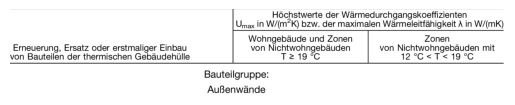

Table Path: //Document/Table[2]
Path: output/Richtlinie BEG EM/Richtlinie_BEG_EM_(2020-12-17)/tables/fileoutpart3.png/n


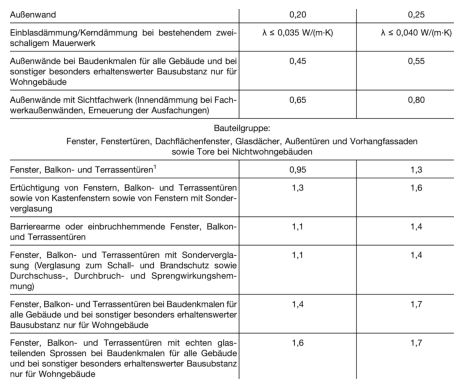

Path: output/Richtlinie BEG EM/Richtlinie_BEG_EM_(2020-12-17)/tables/fileoutpart4.png/n


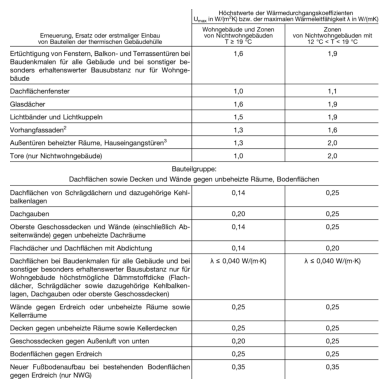

text
Font:TYIAPF+HelveticaNeueLTW1G-Roman_1 - Size:7.0
Content: 1 Umax bezieht sich auf den UW-Wert 
Page: 16

text
Font:TYIAPF+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Sonderverglasungen sind die in Fußnote 4 der Tabelle aus Anlage 7 des Gebäudeenergiegesetzes (GEG) beschriebenen Verglasungen zum Schallschutz, Brandschutz sowie Durchschusshemmung, Durchbruchhemmung oder Sprengwirkungshemmung, die aufgrund von Vorschriften der Landesbauordnung oder anderer Vorschriften für den bestimmungsgemäßen Betrieb eines Gebäudes einzubauen sind. 
Page: 17

text
Font:TYIAPF+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Bei der Erneuerung barrierearmer Fenster, Balkon- und Terrassentüren müssen diese mit einem geringen Kraftaufwand bedient werden können. Beim Ver- und Entriegeln der Fenster muss das Drehmoment am Fenstergriff kleiner als 5 Nm und die auf das Hebelende aufgebrachte Kraft kleiner 30 N sein. Die Fenstergriffe dürfen nicht höher als 1,05 m über dem Fußboden angeordnet sein. Ist 

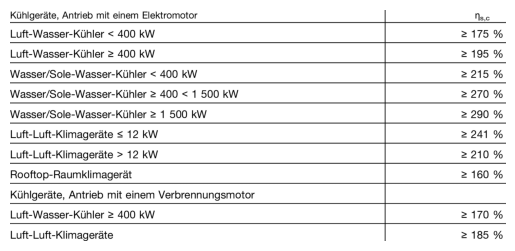

text
Font:TYIAPF+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: –  Die für den Wärmebereich genannten Maßnahmen zur Verteilung und Übergabe gelten analog auch für den Kältebereich. 
Page: 21

text
Font:TYIAPF+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: –  Voraussetzung für die Förderung von Maßnahmen zur Wärme-/Kälteerzeugung, -verteilung und -speicherung ist bei hydraulisch betriebenen Systemen die Durchführung eines hydraulischen Abgleichs des angeschlossenen Verteilsystems. 
Page: 21

text
Font:TYIAPF+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: 2.4.2 
Page: 21

text
Font:TYIAPF+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Nachweise 
Page: 21

text
Font:TYIAPF+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: –  Bestätigung eines Experten der Energieeffizienz-Experten-Liste (www.energie-effizienz-experten.de) 
Page: 21

text
Font:TYIAPF+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: –  Nachweis des hydraulischen Abgleichs (Fachunternehmererklärung) 
Page: 21

text
Font:TYIAPF+He

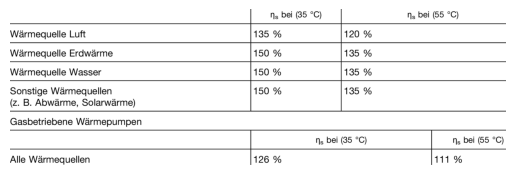

text
Font:TYIAPF+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Wärmepumpen – Beheizung über Luft 
Page: 26

text
Font:TYIAPF+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Elektrisch- und gasbetriebene Wärmepumpen 
Page: 27

text
Font:TYIAPF+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Die „jahreszeitbedingte Raumheizungseffizienz“ ƞs (= ETAs) bzw. der „Raumheizungs-Jahresnutzungsgrad“ ƞs,h (= ETAs,h) gemäß Öko-Design-Richtlinie förderfähiger Wärmepumpen muss bei durchschnittlichen Klimaverhältnissen mindestens folgende Werte erreichen: 
Page: 27

Table Path: //Document/Table[5]
Path: output/Richtlinie BEG EM/Richtlinie_BEG_EM_(2020-12-17)/tables/fileoutpart10.png/n


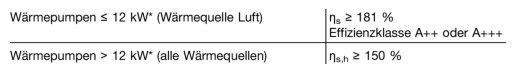

text
Font:TYIAPF+HelveticaNeueLTW1G-Roman_1 - Size:8.0
Content: * Heizleistung, bei Geräten mit Kühlfunktion Kühlleistung (siehe EU 206/2012). 
Page: 27

text
Font:TYIAPF+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: 3.6.3 Netzdienlichkeit 
Page: 27

text
Font:TYIAPF+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Förderfähige Wärmepumpen müssen ab dem 1. Januar 2023 über Schnittstellen verfügen, über die sie automatisiert netzdienlich aktiviert und betrieben werden können (z. B. anhand der Standards „SG Ready“ oder „VHP Ready“). 
Page: 27

text
Font:TYIAPF+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: 3.6.4 Qualitätssicherung 
Page: 27

text
Font:TYIAPF+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Für Sole/Wasser-Wärmepumpen mit neuen Erdwärmesondenbohrungen: 
Page: 27

text
Font:TYIAPF+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: –  Bohrfirmen müssen nach der technischen Regel DVGW W120-2 zertifiziert sein 
Page: 27

text
Font:TYIAPF+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content

In [41]:
# Extract and categorize elements
file_read = 'output/Richtlinie BEG EM/Richtlinie_BEG_EM_(2020-12-17)/structuredData.json'
data = read_json(file_read)
extracted_items = extract_and_categorize_elements(data)
extracted_items2 = merge_elements(extracted_items)
base_path_img = 'output/Richtlinie BEG EM/Richtlinie_BEG_EM_(2020-12-17)/'
print_extracted_elements(extracted_items=extracted_items2,base_path_img=base_path_img)


title
Font:TPUYNE+FuturaLT-Heavy_00 - Size:14.0
Content: Bundesministerium für Wirtschaft und Energie 
Page: 0

text
Font:LNJPGM+HelveticaNeueLTW1G-Bd_0 - Size:10.0
Content: Richtlinie für die Bundesförderung für effiziente Gebäude – Einzelmaßnahmen (BEG EM) 
Page: 0

text
Font:LNJPGM+HelveticaNeueLTW1G-Bd_0 - Size:9.0
Content: Vom 20. Mai 2021 
Page: 0

chapter
Font:LNJPGM+HelveticaNeueLTW1G-Bd_0 - Size:9.0
Content: 1 Präambel 
Page: 0

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Die Richtlinie für die Bundesförderung für effiziente Gebäude – Einzelmaßnahmen in der Fassung vom 20. Mai 2021 ersetzt die Fassung vom 17. Dezember 2020 (BAnz AT 30.12.2020 B2). Mit der Energiewende hat die Bundesrepublik Deutschland eine umfassende und tiefgreifende Transformation ihrer Energieversorgung und Energienutzung eingeleitet. Die Bundesregierung hat sich das Ziel gesetzt, bis 2030 die Treibhausgasemissionen um mindestens 55 % gegenüber dem Basisjahr 1990 zu mindern. Für 2030 gi

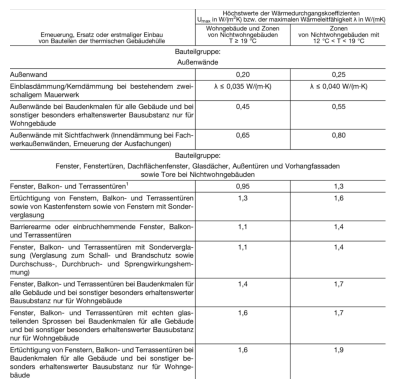

Path: output/Richtlinie BEG EM/Richtlinie_BEG_EM_(2021-05-20)/tables/fileoutpart2.png/n


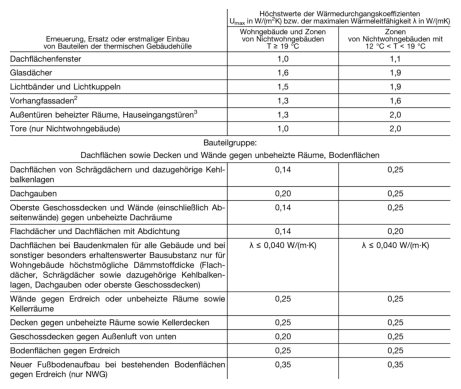

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:7.0
Content: 1 Umax bezieht sich auf den UW-Wert. 
Page: 18

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Sonderverglasungen sind die in Fußnote 4 der Tabelle aus Anlage 7 GEG beschriebenen Verglasungen zum Schallschutz, Brandschutz sowie Durchschusshemmung, Durchbruchhemmung oder Sprengwirkungshemmung, die aufgrund von Vorschriften der Landesbauordnung oder anderer Vorschriften für den bestimmungsgemäßen Betrieb eines Gebäudes einzubauen sind. 
Page: 19

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Bei der Erneuerung barrierearmer Fenster, Balkon- und Terrassentüren müssen diese mit einem geringen Kraftaufwand bedient werden können. Beim Ver- und Entriegeln der Fenster muss das Drehmoment am Fenstergriff kleiner als 5 Nm und die auf das Hebelende aufgebrachte Kraft kleiner 30 N sein. Die Fenstergriffe dürfen nicht höher als 1,05 m über dem Fußboden angeordnet sein. Ist dies baustrukturell nicht mö

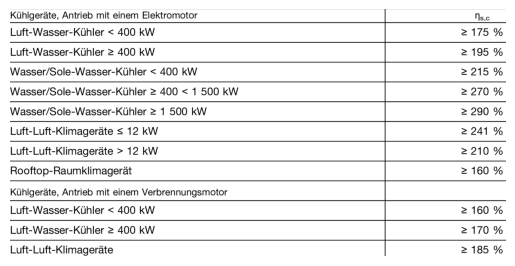

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: –  Die für den Wärmebereich genannten Maßnahmen zur Verteilung und Übergabe gelten analog auch für den Kältebereich. 
Page: 23

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: –  Voraussetzung für die Förderung von Maßnahmen zur Wärme-/Kälteerzeugung, -verteilung und -speicherung ist bei hydraulisch betriebenen Systemen die Durchführung eines hydraulischen Abgleichs des angeschlossenen Verteilsystems. 
Page: 23

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: 2.4.2 
Page: 23

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Nachweise 
Page: 23

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: –  Bestätigung eines Experten der Energieeffizienz-Experten-Liste (www.energie-effizienz-experten.de) 
Page: 23

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: –  Nachweis des hydraulischen Abgleichs (Fachunternehmererklärung) 
Page: 23

text
Font:UBONKY+He

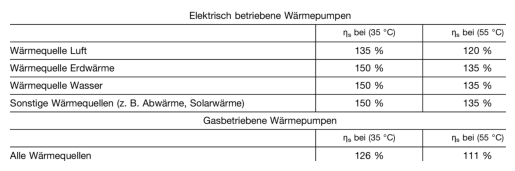

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Wärmepumpen – Beheizung über Luft 
Page: 28

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Die „jahreszeitbedingte Raumheizungseffizienz“ ƞs (= ETAs) bzw. der „Raumheizungs-Jahresnutzungsgrad“ ƞs,h (= ETAs,h) gemäß Öko-Design-Richtlinie förderfähiger Wärmepumpen muss bei durchschnittlichen Klimaverhältnissen mindestens folgende Werte erreichen: 
Page: 28

Table Path: //Document/Table[4]
Path: output/Richtlinie BEG EM/Richtlinie_BEG_EM_(2021-05-20)/tables/fileoutpart8.png/n


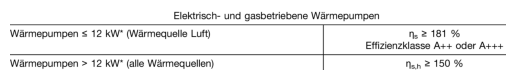

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:8.0
Content: * Heizleistung, bei Geräten mit Kühlfunktion Kühlleistung (siehe EU 206/2012). 
Page: 28

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: 3.6.3 Netzdienlichkeit 
Page: 29

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Förderfähige Wärmepumpen müssen ab dem 1. Januar 2023 über Schnittstellen verfügen, über die sie automatisiert netzdienlich aktiviert und betrieben werden können (z. B. anhand der Standards „SG Ready“ oder „VHP Ready“). 
Page: 29

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: 3.6.4 Qualitätssicherung 
Page: 29

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Für Sole/Wasser-Wärmepumpen mit neuen Erdwärmesondenbohrungen: 
Page: 29

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: –  Bohrfirmen müssen nach der technischen Regel DVGW W120-2 zertifiziert sein 
Page: 29

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content

In [40]:
# Extract and categorize elements
file_read = 'output/Richtlinie BEG EM/Richtlinie_BEG_EM_(2021-05-20)/structuredData.json'
data = read_json(file_read)
extracted_items = extract_and_categorize_elements(data)
extracted_items2 = merge_elements(extracted_items)
base_path_img = 'output/Richtlinie BEG EM/Richtlinie_BEG_EM_(2021-05-20)/'
print_extracted_elements(extracted_items=extracted_items2,base_path_img=base_path_img)


reading file: output/Richtlinie BEG EM/Richtlinie_BEG_EM_(2023-12-21)/structuredData.json
table_paths: output/Richtlinie BEG EM/Richtlinie_BEG_EM_(2023-12-21)


title
Font:WWVPYO+FuturaLT-Heavy_00 - Size:14.0
Content: Bundesministerium 
Page: 0

title
Font:WWVPYO+FuturaLT-Heavy_00 - Size:14.0
Content: für Wirtschaft und Klimaschutz 
Page: 0

text
Font:FKYESK+HelveticaNeueLTW1G-Bd_0 - Size:10.0
Content: Richtlinie für die Bundesförderung für effiziente Gebäude – Einzelmaßnahmen (BEG EM) 
Page: 0

text
Font:FKYESK+HelveticaNeueLTW1G-Bd_0 - Size:9.0
Content: Vom 21. Dezember 2023 
Page: 0

chapter
Font:FKYESK+HelveticaNeueLTW1G-Bd_0 - Size:9.0
Content: 1 Präambel 
Page: 0

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Diese Richtlinie ersetzt die Richtlinie für die Bundesförderung für effiziente Gebäude – Einzelmaßnahmen (BEG EM) vom 9. Dezember 2022 (BAnz AT 30.12.2022 B1). 
Page: 0

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Die Bundesförderung für

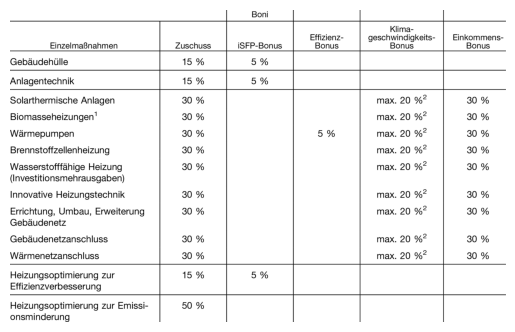

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:7.0
Content: 1 Bei Biomasseheizungen wird bei Einhaltung eines Emissionsgrenzwerts für Staub von 
Page: 9

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:7.0
Content: 2,5 mg/m3 ein zusätzlicher pauschaler Zuschlag gemäß Nummer 8.4.6 gewährt. 
Page: 9

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:7.0
Content: 2 Der Klimageschwindigkeits-Bonus reduziert sich gestaffelt gemäß Nummer 8.4.4. 
Page: 9

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: a) Einzelmaßnahmen an der Gebäudehülle Für Maßnahmen nach Nummer 5.1 beträgt der Fördersatz 15 Prozent.  b) Anlagentechnik (außer Heizung) Für Maßnahmen nach Nummer 5.2 beträgt der Fördersatz 15 Prozent. 
Page: 9

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: c) Anlagen zur Wärmeerzeugung (Heizungstechnik) Für Maßnahmen nach Nummer 5.3 beträgt der Fördersatz 30 Prozent.  d) Heizungsoptimierung 
Page: 9

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size

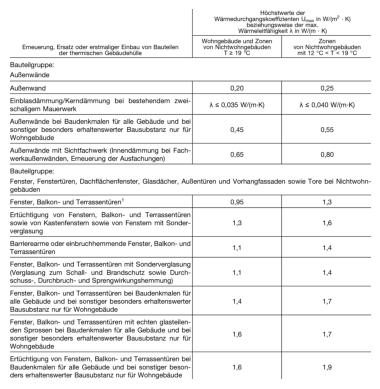

Path: output/Richtlinie BEG EM/Richtlinie_BEG_EM_(2023-12-21)/tables/fileoutpart4.png/n


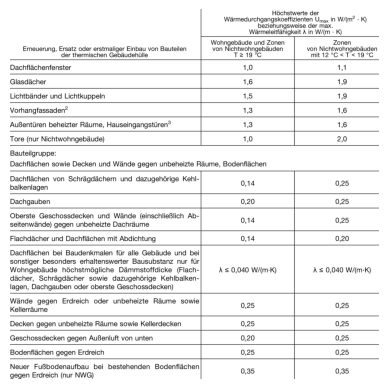

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:7.0
Content: 1 Umax bezieht sich auf den UW-Wert 
Page: 18

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:7.0
Content: 2 Vorhangfassaden, deren Bauart in DIN Euronorm 12631:2018-01 beschrieben ist, Umax bezieht sich auf den UCW-Wert 
Page: 18

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:7.0
Content: 3 Umax bezieht sich auf den UD-Wert 
Page: 18

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Sonderverglasungen sind die in Fußnote 4 der Tabelle aus Anlage 7 des GEG beschriebenen Verglasungen zum Schallschutz, Brandschutz sowie zur Durchschusshemmung, Durchbruchhemmung oder Sprengwirkungshemmung, die aufgrund von Vorschriften der Landesbauordnung oder anderer Vorschriften für den bestimmungsgemäßen Betrieb eines Gebäudes einzubauen sind. 
Page: 18

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Bei der Erneuerung barrierearmer Fenster, Balkon- und Terrassentüren müssen diese mit einem geringe

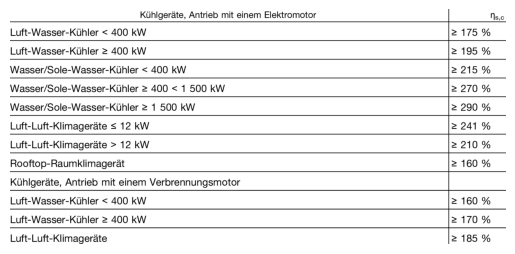

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: –  Die für den Wärmebereich genannten Maßnahmen zur Verteilung und Übergabe gelten analog auch für den Kältebereich. 
Page: 22

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: –  Voraussetzung für die Förderung von Maßnahmen zur Wärme-/Kälteerzeugung, -verteilung und -speicherung ist bei hydraulisch betriebenen Systemen die Durchführung eines hydraulischen Abgleichs des angeschlossenen Verteilsystems. 
Page: 22

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: 2.4.2 
Page: 22

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Nachweise 
Page: 22

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: –  Bestätigung eines Experten der Energieeffizienz-Experten-Liste (www.energie-effizienz-experten.de) 
Page: 22

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: –  Nachweis des hydraulischen Abgleichs (Fachunternehmererklärung) 
Page: 22

text
Font:UBONKY+He

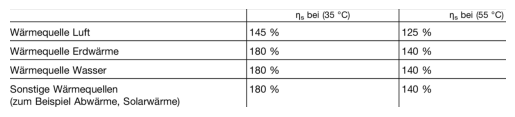

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Wärmepumpen – Beheizung über Luft 
Page: 25

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Die „jahreszeitbedingte Raumheizungs-Energieeffizienz“ ƞs (= ETAs) beziehungsweise der „Raumheizungs-Jahresnutzungsgrad“ ƞs, h (= ETAs, h) gemäß Öko-Design-Richtlinie förderfähiger Wärmepumpen muss bei durchschnittlichen Klimaverhältnissen mindestens folgende Werte erreichen: 
Page: 25

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Wärmepumpen ≤ 12 kW* (Wärmequelle Luft) 
Page: 25

text
Font: - Size:0
Content: 
Page: 25

text
Font:SWCPVI+ArialUnicodeMS_00 - Size:9.0
Content: ƞs ≥ 181 % Effizienzklasse A++ oder A+++ 
Page: 25

text
Font:SWCPVI+ArialUnicodeMS_00 - Size:9.0
Content: Wärmepumpen > 12 kW* (alle Wärmequellen) ƞs, h ≥ 150 % 
Page: 25

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:7.0
Content: * Heizleistung, bei Geräten mit Kühlfunktion Kühlleistung (siehe EU 206/2012). 
Page: 25

te

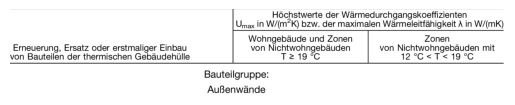

Table Path: //Document/Table[2]
Path: output/Richtlinie BEG EM/Richtlinie_BEG_EM_(2020-12-17)/tables/fileoutpart3.png/n


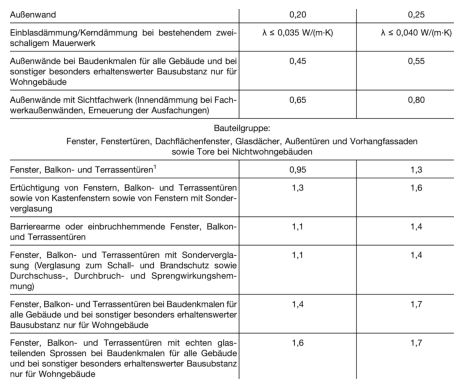

Path: output/Richtlinie BEG EM/Richtlinie_BEG_EM_(2020-12-17)/tables/fileoutpart4.png/n


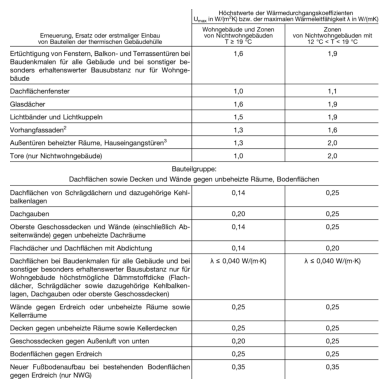

text
Font:TYIAPF+HelveticaNeueLTW1G-Roman_1 - Size:7.0
Content: 1 Umax bezieht sich auf den UW-Wert 
Page: 16

text
Font:TYIAPF+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Sonderverglasungen sind die in Fußnote 4 der Tabelle aus Anlage 7 des Gebäudeenergiegesetzes (GEG) beschriebenen Verglasungen zum Schallschutz, Brandschutz sowie Durchschusshemmung, Durchbruchhemmung oder Sprengwirkungshemmung, die aufgrund von Vorschriften der Landesbauordnung oder anderer Vorschriften für den bestimmungsgemäßen Betrieb eines Gebäudes einzubauen sind. 
Page: 17

text
Font:TYIAPF+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Bei der Erneuerung barrierearmer Fenster, Balkon- und Terrassentüren müssen diese mit einem geringen Kraftaufwand bedient werden können. Beim Ver- und Entriegeln der Fenster muss das Drehmoment am Fenstergriff kleiner als 5 Nm und die auf das Hebelende aufgebrachte Kraft kleiner 30 N sein. Die Fenstergriffe dürfen nicht höher als 1,05 m über dem Fußboden angeordnet sein. Ist 

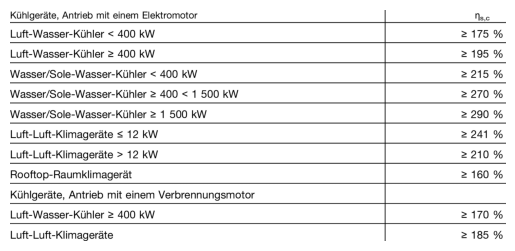

text
Font:TYIAPF+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: –  Die für den Wärmebereich genannten Maßnahmen zur Verteilung und Übergabe gelten analog auch für den Kältebereich. 
Page: 21

text
Font:TYIAPF+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: –  Voraussetzung für die Förderung von Maßnahmen zur Wärme-/Kälteerzeugung, -verteilung und -speicherung ist bei hydraulisch betriebenen Systemen die Durchführung eines hydraulischen Abgleichs des angeschlossenen Verteilsystems. 
Page: 21

text
Font:TYIAPF+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: 2.4.2 
Page: 21

text
Font:TYIAPF+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Nachweise 
Page: 21

text
Font:TYIAPF+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: –  Bestätigung eines Experten der Energieeffizienz-Experten-Liste (www.energie-effizienz-experten.de) 
Page: 21

text
Font:TYIAPF+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: –  Nachweis des hydraulischen Abgleichs (Fachunternehmererklärung) 
Page: 21

text
Font:TYIAPF+He

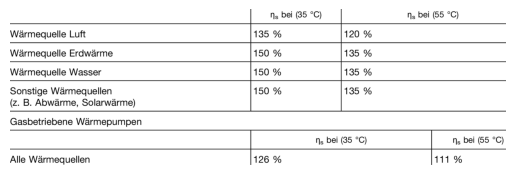

text
Font:TYIAPF+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Wärmepumpen – Beheizung über Luft 
Page: 26

text
Font:TYIAPF+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Elektrisch- und gasbetriebene Wärmepumpen 
Page: 27

text
Font:TYIAPF+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Die „jahreszeitbedingte Raumheizungseffizienz“ ƞs (= ETAs) bzw. der „Raumheizungs-Jahresnutzungsgrad“ ƞs,h (= ETAs,h) gemäß Öko-Design-Richtlinie förderfähiger Wärmepumpen muss bei durchschnittlichen Klimaverhältnissen mindestens folgende Werte erreichen: 
Page: 27

Table Path: //Document/Table[5]
Path: output/Richtlinie BEG EM/Richtlinie_BEG_EM_(2020-12-17)/tables/fileoutpart10.png/n


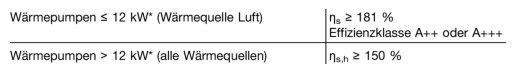

text
Font:TYIAPF+HelveticaNeueLTW1G-Roman_1 - Size:8.0
Content: * Heizleistung, bei Geräten mit Kühlfunktion Kühlleistung (siehe EU 206/2012). 
Page: 27

text
Font:TYIAPF+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: 3.6.3 Netzdienlichkeit 
Page: 27

text
Font:TYIAPF+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Förderfähige Wärmepumpen müssen ab dem 1. Januar 2023 über Schnittstellen verfügen, über die sie automatisiert netzdienlich aktiviert und betrieben werden können (z. B. anhand der Standards „SG Ready“ oder „VHP Ready“). 
Page: 27

text
Font:TYIAPF+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: 3.6.4 Qualitätssicherung 
Page: 27

text
Font:TYIAPF+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Für Sole/Wasser-Wärmepumpen mit neuen Erdwärmesondenbohrungen: 
Page: 27

text
Font:TYIAPF+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: –  Bohrfirmen müssen nach der technischen Regel DVGW W120-2 zertifiziert sein 
Page: 27

text
Font:TYIAPF+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content

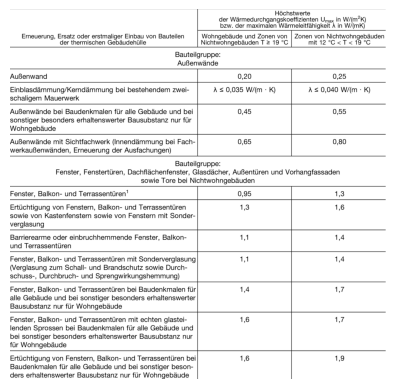

Path: output/Richtlinie BEG EM/Richtlinie_BEG_EM_(2021-09-16)/tables/fileoutpart2.png/n


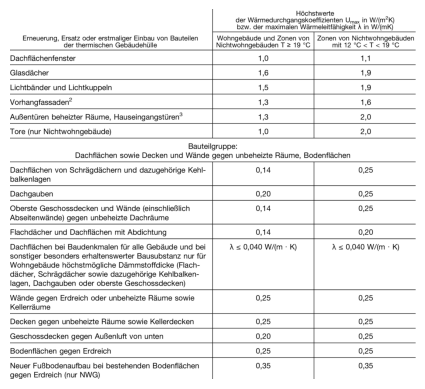

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:7.0
Content: 1 Umax bezieht sich auf den UW-Wert 
Page: 18

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Sonderverglasungen sind die in Fußnote 4 der Tabelle aus Anlage 7 des Gebäudeenergiegesetzes (GEG) beschriebenen Verglasungen zum Schallschutz, Brandschutz sowie Durchschusshemmung, Durchbruchhemmung oder Sprengwirkungshemmung, die aufgrund von Vorschriften der Landesbauordnung oder anderer Vorschriften für den bestimmungsgemäßen Betrieb eines Gebäudes einzubauen sind. 
Page: 19

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Bei der Erneuerung barrierearmer Fenster, Balkon- und Terrassentüren müssen diese mit einem geringen Kraftaufwand bedient werden können. Beim Ver- und Entriegeln der Fenster muss das Drehmoment am Fenstergriff kleiner als 5 Nm und die auf das Hebelende aufgebrachte Kraft kleiner 30 N sein. Die Fenstergriffe dürfen nicht höher als 1,05 m über dem Fußboden angeordnet sein. Ist 

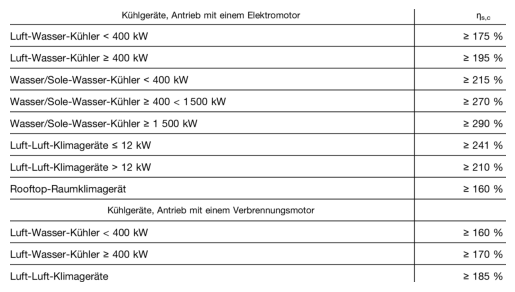

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: –  Die für den Wärmebereich genannten Maßnahmen zur Verteilung und Übergabe gelten analog auch für den Kältebereich. 
Page: 23

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: –  Voraussetzung für die Förderung von Maßnahmen zur Wärme-/Kälteerzeugung, -verteilung und -speicherung ist bei hydraulisch betriebenen Systemen die Durchführung eines hydraulischen Abgleichs des angeschlossenen Verteilsystems. 
Page: 23

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: 2.4.2 
Page: 23

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Nachweise 
Page: 23

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: –  Bestätigung eines Experten der Energieeffizienz-Experten-Liste (www.energie-effizienz-experten.de) 
Page: 23

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: –  Nachweis des hydraulischen Abgleichs (Fachunternehmererklärung) 
Page: 23

text
Font:UBONKY+He

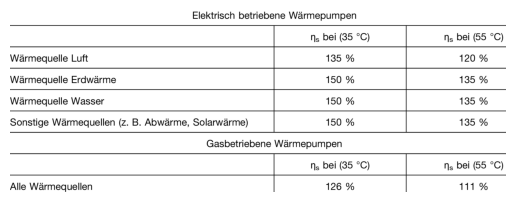

Table Path: //Document/Table[4]
Path: output/Richtlinie BEG EM/Richtlinie_BEG_EM_(2021-09-16)/tables/fileoutpart8.png/n


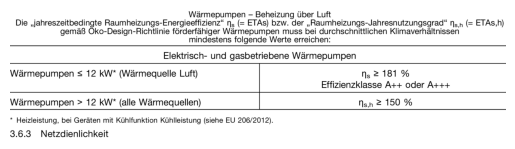

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: –  Herstellernachweis nach Nummer 3.6.3 (Netzdienlichkeit) 
Page: 29

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: –  Herstellernachweise zu den weiteren produktspezifischen Kenndaten und Geräteeigenschaften 
Page: 29

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: 3.7 
Page: 29

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Innovative Heiztechnik auf Basis erneuerbarer Energien 
Page: 29

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Gefördert wird die Errichtung von innovativen effizienten Heizungsanlagen, die auf der Nutzung von erneuerbaren Energien basieren und erneuerbare Energien für die Wärmeerzeugung mit einem Anteil von mindestens 80 % der Gebäudeheizlast einbinden, soweit sie nicht unter die Nummern 3.2 bis 3.6 fallen. 
Page: 29

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Förderfähige innovative Heizungsanlagen sind in e

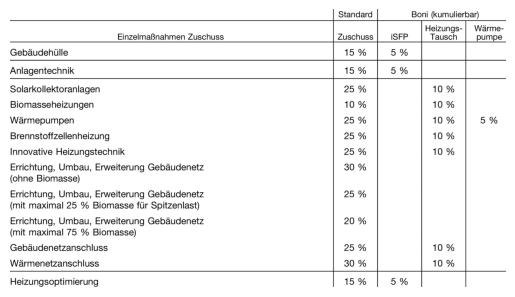

text
Font:DMTLBB+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: a) Einzelmaßnahmen an der Gebäudehülle Für Maßnahmen nach Nummer 5.1 beträgt der Fördersatz 15 %.  b) Anlagentechnik (außer Heizung) Für Maßnahmen nach Nummer 5.2 beträgt der Fördersatz 15 %. 
Page: 8

text
Font:DMTLBB+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: c)  Anlagen zur Wärmeerzeugung (Heizungstechnik) 
Page: 8

text
Font:DMTLBB+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Für Solarkollektoranlagen nach Nummer 5.3 Buchstabe a beträgt der Fördersatz 25 %. 
Page: 8

text
Font:DMTLBB+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Für Biomasseheizungen nach Nummer 5.3 Buchstabe b beträgt der Fördersatz 10 %. 
Page: 8

text
Font:DMTLBB+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Für Wärmepumpen nach Nummer 5.3 Buchstabe c beträgt der Fördersatz 25 %. Für Wärmepumpen wird zusätzlich ein Bonus von 5 Prozentpunkten gewährt, wenn als Wärmequelle Wasser, Erdreich oder Abwasser erschlossen wird oder ein natürliches Kä

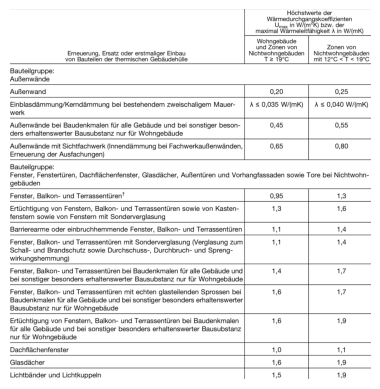

Path: output/Richtlinie BEG EM/Richtlinie_BEG_EM_(2022-12-09)/tables/fileoutpart4.png/n


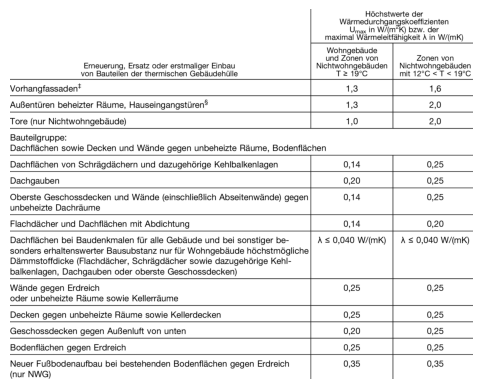

text
Font:DMTLBB+HelveticaNeueLTW1G-Roman_1 - Size:7.0
Content: † Umax bezieht sich auf den UW-Wert 
Page: 15

text
Font:DMTLBB+HelveticaNeueLTW1G-Roman_1 - Size:7.0
Content: ‡ Vorhangfassaden, deren Bauart in DIN Euronorm 12631:2018-01 beschrieben ist, Umax bezieht sich auf den UCW-Wert 
Page: 15

text
Font:DMTLBB+HelveticaNeueLTW1G-Roman_1 - Size:7.0
Content: § Umax bezieht sich auf den UD-Wert 
Page: 15

text
Font:DMTLBB+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Sonderverglasungen sind die in Fußnote 4 der Tabelle aus Anlage 7 des Gebäudeenergiegesetzes (GEG) beschriebenen Verglasungen zum Schallschutz, Brandschutz sowie Durchschusshemmung, Durchbruchhemmung oder Sprengwirkungshemmung, die aufgrund von Vorschriften der Landesbauordnung oder anderer Vorschriften für den bestimmungsgemäßen Betrieb eines Gebäudes einzubauen sind. 
Page: 15

text
Font:DMTLBB+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Bei der Erneuerung barrierearmer Fenster, Balkon- und Terrassentüren müssen di

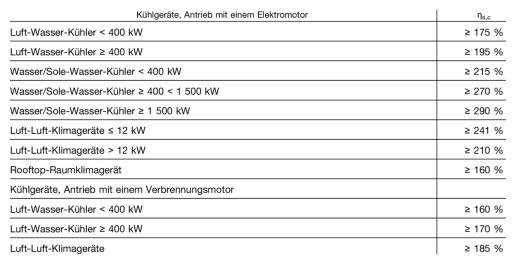

text
Font:DMTLBB+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: –  Die für den Wärmebereich genannten Maßnahmen zur Verteilung und Übergabe gelten analog auch für den Kältebereich. 
Page: 19

text
Font:DMTLBB+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: –  Voraussetzung für die Förderung von Maßnahmen zur Wärme-/Kälteerzeugung, -verteilung und -speicherung ist bei hydraulisch betriebenen Systemen die Durchführung eines hydraulischen Abgleichs des angeschlossenen Verteilsystems. 
Page: 19

text
Font:DMTLBB+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: 2.4.2 
Page: 19

text
Font:DMTLBB+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Nachweise 
Page: 19

text
Font:DMTLBB+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: –  Bestätigung eines Experten der Energieeffizienz-Experten-Liste (www.energie-effizienz-experten.de) 
Page: 19

text
Font:DMTLBB+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: –  Nachweis des hydraulischen Abgleichs (Fachunternehmererklärung) 
Page: 19

text
Font:DMTLBB+He

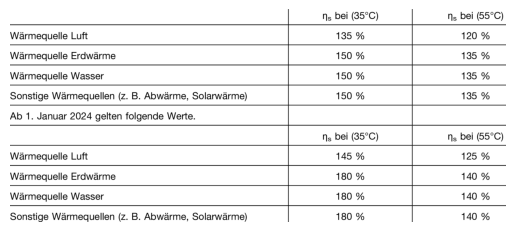

text
Font:DMTLBB+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Wärmepumpen – Beheizung über Luft 
Page: 23

text
Font:DMTLBB+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Die „jahreszeitbedingte Raumheizungs-Energieeffizienz“ ƞs (= ETAs) bzw. der „Raumheizungs-Jahresnutzungsgrad“ ƞs,h (= ETAs,h) gemäß Öko-Design-Richtlinie förderfähiger Wärmepumpen muss bei durchschnittlichen Klimaverhältnissen mindestens folgende Werte erreichen: 
Page: 23

Table Path: //Document/Table[5]
Path: output/Richtlinie BEG EM/Richtlinie_BEG_EM_(2022-12-09)/tables/fileoutpart10.png/n


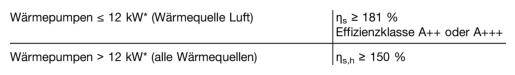

text
Font:DMTLBB+HelveticaNeueLTW1G-Roman_1 - Size:7.0
Content: * Heizleistung, bei Geräten mit Kühlfunktion Kühlleistung (siehe EU 206/2012). 
Page: 23

text
Font:DMTLBB+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: 3.4.3 Netzdienlichkeit 
Page: 23

text
Font:DMTLBB+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Förderfähige Wärmepumpen müssen über Schnittstellen verfügen, über die sie automatisiert netzdienlich aktiviert und betrieben werden können (z. B. anhand der Standards „SG Ready“ oder „VHP Ready“). Es wird empfohlen, dass Wärmepumpen an ein zertifiziertes Smart-Meter-Gateway angeschlossen werden können, damit energiewirtschaftlich relevante Mess- und Steuerungsvorgänge über ein Smart-Meter-Gateway entsprechend den Anforderungen des Energiewirtschaftsgesetzes und des Messstellenbetriebsgesetzes abgewickelt werden können. Ab dem 1. Januar 2025 werden nur noch Wärmepumpen gefördert, die diese Anforderung erfüllen. 
Page: 23

text
Font:DMTLBB+HelveticaNeueLTW1G-Roman_1 - Size:9.0

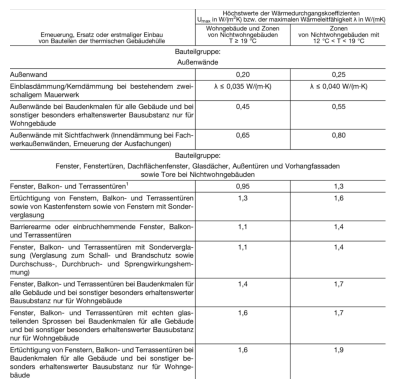

Path: output/Richtlinie BEG EM/Richtlinie_BEG_EM_(2021-05-20)/tables/fileoutpart2.png/n


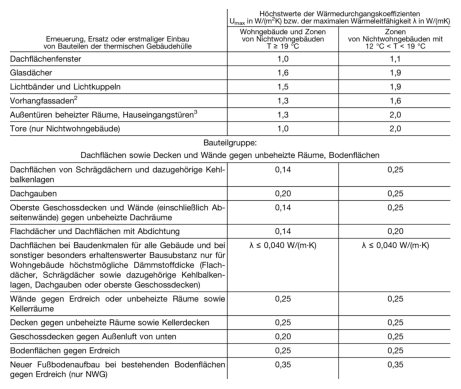

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:7.0
Content: 1 Umax bezieht sich auf den UW-Wert. 
Page: 18

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Sonderverglasungen sind die in Fußnote 4 der Tabelle aus Anlage 7 GEG beschriebenen Verglasungen zum Schallschutz, Brandschutz sowie Durchschusshemmung, Durchbruchhemmung oder Sprengwirkungshemmung, die aufgrund von Vorschriften der Landesbauordnung oder anderer Vorschriften für den bestimmungsgemäßen Betrieb eines Gebäudes einzubauen sind. 
Page: 19

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Bei der Erneuerung barrierearmer Fenster, Balkon- und Terrassentüren müssen diese mit einem geringen Kraftaufwand bedient werden können. Beim Ver- und Entriegeln der Fenster muss das Drehmoment am Fenstergriff kleiner als 5 Nm und die auf das Hebelende aufgebrachte Kraft kleiner 30 N sein. Die Fenstergriffe dürfen nicht höher als 1,05 m über dem Fußboden angeordnet sein. Ist dies baustrukturell nicht mö

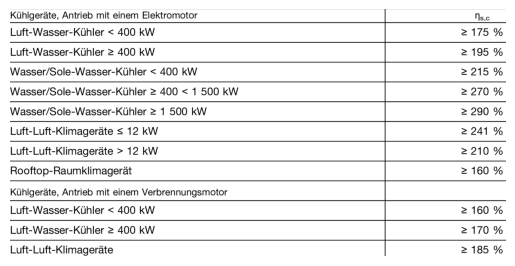

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: –  Die für den Wärmebereich genannten Maßnahmen zur Verteilung und Übergabe gelten analog auch für den Kältebereich. 
Page: 23

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: –  Voraussetzung für die Förderung von Maßnahmen zur Wärme-/Kälteerzeugung, -verteilung und -speicherung ist bei hydraulisch betriebenen Systemen die Durchführung eines hydraulischen Abgleichs des angeschlossenen Verteilsystems. 
Page: 23

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: 2.4.2 
Page: 23

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Nachweise 
Page: 23

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: –  Bestätigung eines Experten der Energieeffizienz-Experten-Liste (www.energie-effizienz-experten.de) 
Page: 23

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: –  Nachweis des hydraulischen Abgleichs (Fachunternehmererklärung) 
Page: 23

text
Font:UBONKY+He

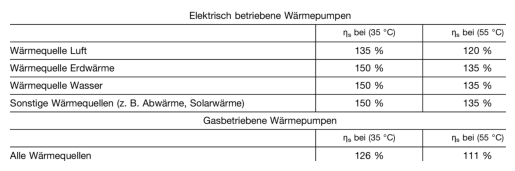

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Wärmepumpen – Beheizung über Luft 
Page: 28

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Die „jahreszeitbedingte Raumheizungseffizienz“ ƞs (= ETAs) bzw. der „Raumheizungs-Jahresnutzungsgrad“ ƞs,h (= ETAs,h) gemäß Öko-Design-Richtlinie förderfähiger Wärmepumpen muss bei durchschnittlichen Klimaverhältnissen mindestens folgende Werte erreichen: 
Page: 28

Table Path: //Document/Table[4]
Path: output/Richtlinie BEG EM/Richtlinie_BEG_EM_(2021-05-20)/tables/fileoutpart8.png/n


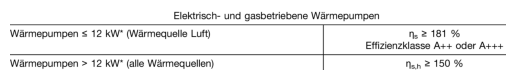

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:8.0
Content: * Heizleistung, bei Geräten mit Kühlfunktion Kühlleistung (siehe EU 206/2012). 
Page: 28

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: 3.6.3 Netzdienlichkeit 
Page: 29

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Förderfähige Wärmepumpen müssen ab dem 1. Januar 2023 über Schnittstellen verfügen, über die sie automatisiert netzdienlich aktiviert und betrieben werden können (z. B. anhand der Standards „SG Ready“ oder „VHP Ready“). 
Page: 29

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: 3.6.4 Qualitätssicherung 
Page: 29

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: Für Sole/Wasser-Wärmepumpen mit neuen Erdwärmesondenbohrungen: 
Page: 29

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content: –  Bohrfirmen müssen nach der technischen Regel DVGW W120-2 zertifiziert sein 
Page: 29

text
Font:UBONKY+HelveticaNeueLTW1G-Roman_1 - Size:9.0
Content

In [19]:
directory_richtlinie = 'output/Richtlinie BEG EM/'

files_dir = os.listdir(directory_richtlinie)
directories_read = [i for i in files_dir if os.path.isdir(os.path.join(directory_richtlinie,i))]

for i in directories_read:
    directory_i_files = os.listdir(os.path.join(directory_richtlinie,i))
    json_files = [file for file in directory_i_files if file.endswith('.json')]
    # print(json_files)
    for j in json_files:
        file_read = os.path.join(directory_richtlinie,i,j)
        print(f'reading file: {file_read}')
        data = read_json(file_read)
        extracted_items = extract_and_categorize_elements(data)
        extracted_items2 = merge_elements(extracted_items)
        base_path_img = os.path.join(directory_richtlinie,i)
        print(f'table_paths: {base_path_img} \n\n')
        print_extracted_elements(extracted_items2,base_path_img)
        print('=================\n\n=================\n\n')




# # Extract and categorize elements
# file_read = 'output/Richtlinie BEG EM/Richtlinie_BEG_EM_(2020-12-17)/structuredData.json'
# data = read_json(file_read)
# extracted_items = extract_and_categorize_elements(data)
# extracted_items2 = merge_elements(extracted_items)
# base_path_img = 'output/Richtlinie BEG EM/Richtlinie_BEG_EM_(2020-12-17)/'
# print_extracted_elements(extracted_items=extracted_items2,base_path_img=base_path_img)

In [21]:
import os
import base64
import requests
from dotenv import load_dotenv
import openai
from IPython.display import Image, display, Audio, Markdown

load_dotenv()

#API_KEY = os.getenv('API_KEY')
API_KEY_CGPT = os.getenv('API_KEY_CGPT')

# OpenAI API Key
api_key = "YOUR_OPENAI_API_KEY"

# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')


## Set the API key and model name
MODEL="gpt-4o"

openai.api_key = API_KEY_CGPT




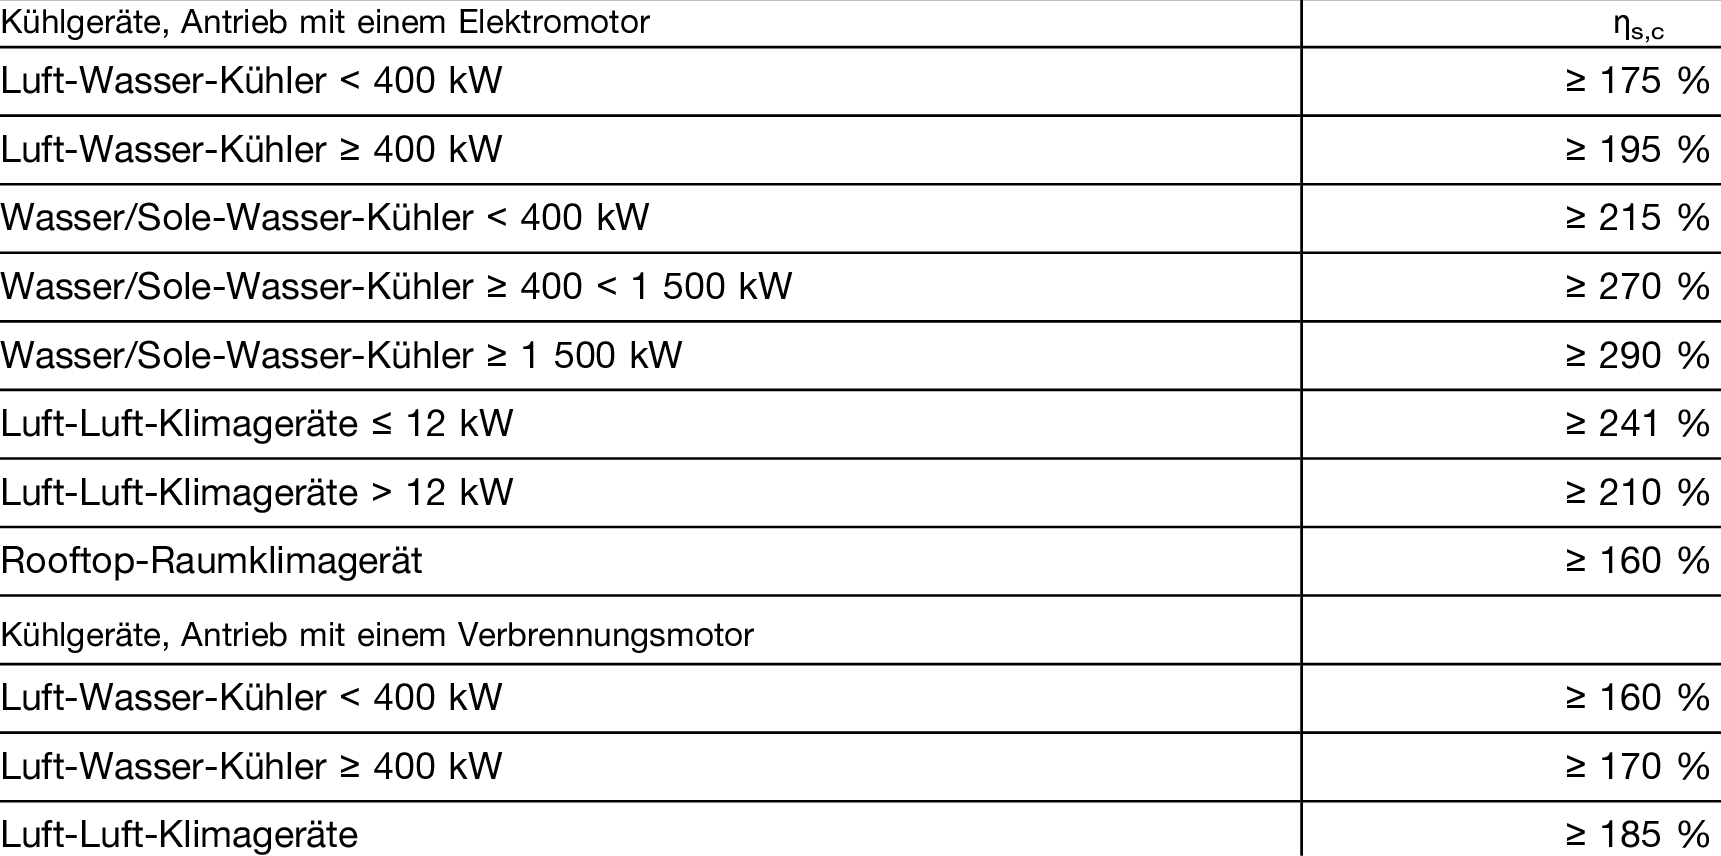

Die Tabelle zeigt die Effizienzanforderungen (ηs,c) für verschiedene Kühlgeräte, die entweder mit einem Elektromotor oder einem Verbrennungsmotor betrieben werden. Hier sind die wichtigsten Kategorien und ihre zugehörigen Werte:

**Kühlgeräte, Antrieb mit einem Elektromotor:**
- Luft-Wasser-Kühler < 400 kW: ≥ 175 %
- Luft-Wasser-Kühler ≥ 400 kW: ≥ 195 %
- Wasser/Sole-Wasser-Kühler < 400 kW: ≥ 215 %
- Wasser/Sole-Wasser-Kühler ≥ 400 < 1 500 kW: ≥ 270 %
- Wasser/Sole-Wasser-Kühler ≥ 1 500 kW: ≥ 290 %
- Luft-Luft-Klimageräte ≤ 12 kW: ≥ 241 %
- Luft-Luft-Klimageräte > 12 kW: ≥ 210 %
- Rooftop-Raumklimagerät: ≥ 160 %

**Kühlgeräte, Antrieb mit einem Verbrennungsmotor:**
- Luft-Wasser-Kühler < 400 kW: ≥ 160 %
- Luft-Wasser-Kühler ≥ 400 kW: ≥ 170 %
- Luft-Luft-Klimageräte: ≥ 185 %


In [26]:
# Path to your image
image_path = "output/Richtlinie BEG EM/Richtlinie_BEG_EM_(2021-05-20)/tables/fileoutpart4.png"
display(Image(image_path))

# Getting the base64 string
base64_image = encode_image(image_path)


response = openai.chat.completions.create(
    model=MODEL,
    messages=[
        {"role": "system", "content": """Please provide a concise summary of the following table in German. Highlight the key categories and their associated values, focusing on any significant numbers or ranges. Ensure the summary is clear, concise, and suitable for embedding in a retrieval system."""},
        {"role": "user", "content": [
            {"type": "text", "text": "Summarize the following image:"},
            {"type": "image_url", "image_url": {
                "url": f"data:image/png;base64,{base64_image}"}
            }
        ]}
    ],
    temperature=0.0,
)

print(response.choices[0].message.content)